In [1]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('Combined_Secondary_Defense.csv')
metric = 'Current_PFF'  # Metric to predict

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'Team', 'Year', 'Position', 'Value_cap_space',
       'Value_draft_data', 'Current_AV', 'Current_PFF', 'Total DVOA',
       'win-loss-pct',
       ...
       'Previous_snap_counts_slot', 'Previous_stops', 'Previous_tackles',
       'Previous_tackles_for_loss', 'Previous_targets',
       'Previous_total_pressures', 'Previous_touchdowns', 'Previous_yards',
       'Previous_yards_after_catch', 'Previous_yards_per_reception'],
      dtype='object', length=117)


In [4]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop)

In [5]:
# Sort data by Team and Year
df = df.sort_values(by=['Team', 'Year'])
print(df.head())

      Team  Year Position  Value_cap_space  Value_draft_data  Current_AV  \
17   49ers  2019       DB        15.313496        270.589442        35.0   
50   49ers  2020       DB        13.657921        257.525536        36.0   
70   49ers  2021       DB         7.895890        247.080988        34.0   
123  49ers  2022       DB        11.383285        101.033420        45.0   
12   Bears  2019       DB        19.373007        241.860963        43.0   

     Current_PFF Total DVOA  win-loss-pct  Net EPA  ...  \
17     74.600742     27.90%      0.812500    0.216  ...   
50     66.704119      5.40%      0.375000    0.025  ...   
70     62.219454     19.50%      0.588235    0.081  ...   
123    69.627066     27.60%      0.764706    0.196  ...   
12     66.382439     -2.10%      0.500000   -0.032  ...   

     Previous_snap_counts_slot  Previous_stops  Previous_tackles  \
17                  105.954181        8.742204         29.438840   
50                  120.219801       12.132261      

In [6]:
team_data = df.groupby('Team')

In [7]:
import numpy as np

sequences = []
targets = []

# Iterate over each team and its respective data
for team, group in team_data:
    # Ensure the team has at least 4 years of data
    if len(group) >= 4:
        print(f"Processing team: {team}, data length: {len(group)}")  # Debugging: check length of data for each team
        
        # Iterate through the data to create sequences for 3 years
        for i in range(len(group) - 3):
            # Select the relevant columns for the sequence
            sequence = group.iloc[i:i+3][['Previous_grades_tackle', 'Previous_AV',
                                            'Previous_PFF',
                                            'Previous_franchise_id',
                                            'Previous_grades_run_defense',
                                            'Previous_grades_coverage_defense',
                                            'Previous_tackles_for_loss']]  # Add more columns if needed
            
            # The target is the next year's Current_PFF
            target = group.iloc[i+3]['Current_PFF']  
            
            sequences.append(sequence.values)  # Add the sequence to the list
            targets.append(target)  # Add the target to the list

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(targets)



print(f"Total sequences generated: {len(sequences)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Processing team: 49ers, data length: 4
Processing team: Bears, data length: 4
Processing team: Bengals, data length: 4
Processing team: Bills, data length: 4
Processing team: Broncos, data length: 4
Processing team: Browns, data length: 4
Processing team: Buccaneers, data length: 4
Processing team: Cardinals, data length: 4
Processing team: Chargers, data length: 4
Processing team: Chiefs, data length: 4
Processing team: Colts, data length: 4
Processing team: Commanders, data length: 4
Processing team: Cowboys, data length: 4
Processing team: Dolphins, data length: 4
Processing team: Eagles, data length: 4
Processing team: Falcons, data length: 4
Processing team: Giants, data length: 4
Processing team: Jaguars, data length: 4
Processing team: Jets, data length: 4
Processing team: Lions, data length: 4
Processing team: Packers, data length: 4
Processing team: Panthers, data length: 4
Processing team: Patriots, data length: 4
Processing team: Raiders, data length: 4
Processing team: Rams

In [8]:
# Check shape before reshaping
print(X)
print(X.shape)

# Reshape X to (samples, timesteps, features)
X = X.reshape(X.shape[0], 3, -1)  # 3 years per sequence, features will be inferred

print(X.shape)  # Should now be (samples, 3, features)
print(X)

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

[[[60.18003406 29.         56.96510714 28.         67.75277437
   55.08925533  1.80849409]
  [59.34648658 35.         74.60074166 28.         69.56141715
   73.95167181  1.79530333]
  [65.4289868  36.         66.70411885 28.         70.59421169
   64.43871668  0.8834877 ]]

 [[68.34141273 49.         83.15682879  6.         73.21140016
   83.42233101  1.6032921 ]
  [61.86186275 43.         66.38243854  6.         68.44952585
   65.93286816  1.59863093]
  [58.26601136 33.         60.72455662  6.         60.43048506
   60.20632252  0.58751767]]

 [[58.82703144 24.         70.5970905   7.         69.36530587
   71.49349449  1.18867841]
  [54.12743187 27.         58.06420444  7.         54.97966047
   59.00410277  1.76290475]
  [67.65442276 30.         69.52536358  7.         65.82612226
   67.42535476  1.97082946]]

 [[58.15197266 35.         69.94821906  4.         62.06269992
   71.55616136  2.11372616]
  [58.97224099 51.         72.72997731  4.         66.85490119
   72.17233736  2.530

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Define the input layer
inputs = Input(shape=(3, 7))  # 3 time steps, 8 features

# Add a Dense layer before the attention to create more variability in the input
dense_input = Dense(16, activation='relu')(inputs)

# Add MultiHeadAttention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)

# Add Layer Normalization for stability
attention_output = LayerNormalization()(attention_output)

# Add RNN layer to capture temporal dependencies
rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)

# Add Dropout to prevent overfitting
rnn_output = Dropout(0.2)(rnn_output)

# Output layer for predicting Current PFF
output = Dense(1)(rnn_output)

# Define the model
model = Model(inputs=inputs, outputs=output)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Early stopping callback to monitor validation loss
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4278.6470 - val_loss: 4243.0962
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4111.4375 - val_loss: 4132.1851
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4041.9368 - val_loss: 4027.1150
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3915.8862 - val_loss: 3916.7908
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3834.1284 - val_loss: 3795.7258


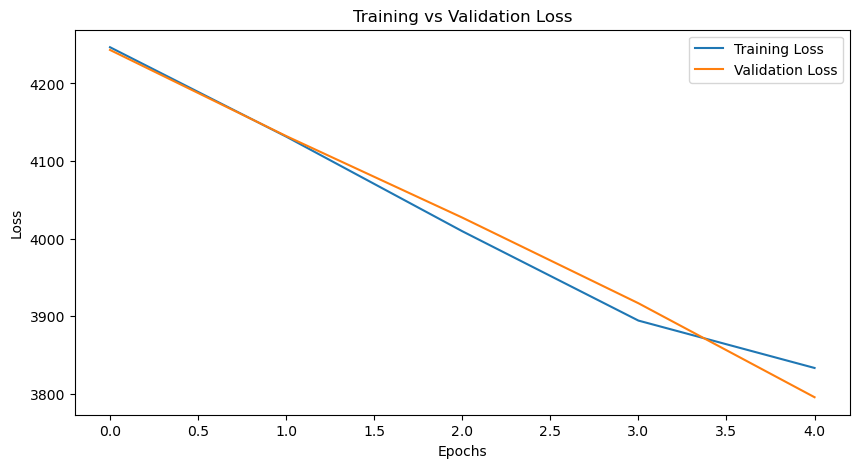

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
R² Score: -333.9587


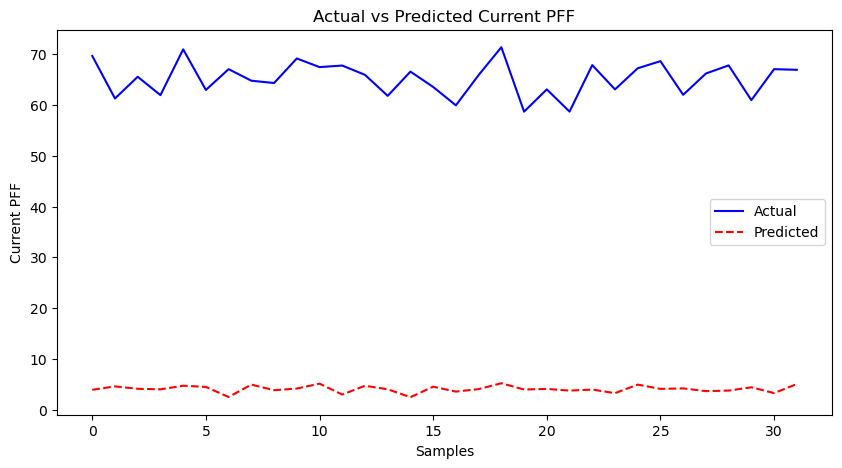

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3675.4165 - val_loss: 3654.3589
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3556.7141 - val_loss: 3480.9419
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3417.4507 - val_loss: 3275.0620
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3192.7000 - val_loss: 3016.8560
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2958.0383 - val_loss: 2691.8618
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2547.8589 - val_loss: 2269.4788
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2134.4260 - val_loss: 1773.6697
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1587.1820 - val_loss: 1229.1906
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1129.8864 - val_loss: 688.1342
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 587.4663 - val_loss: 252.5454


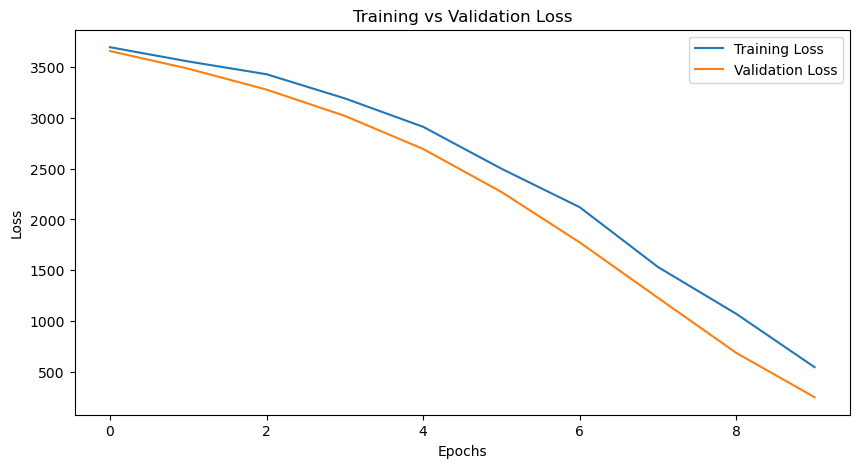

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -20.1926


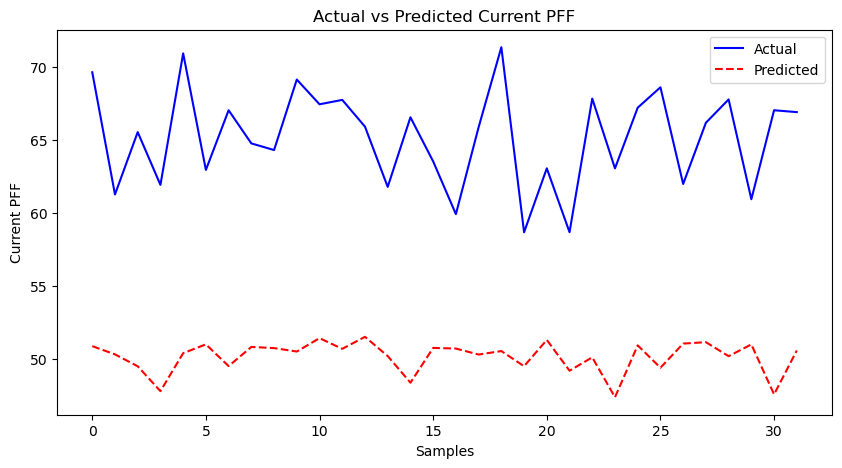

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 225.4719 - val_loss: 28.8946
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.9697 - val_loss: 39.9759
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 121.0899 - val_loss: 106.4222
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 235.8963 - val_loss: 72.0563
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 157.7352 - val_loss: 17.9640
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.5609 - val_loss: 17.0040
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 117.3570 - val_loss: 33.0412
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.3325 - val_loss: 40.5513
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.7803 - val_loss: 42.6592
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.2573 - val_loss: 32.6738
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.7532 - val_loss: 21.8986
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.6033 - 

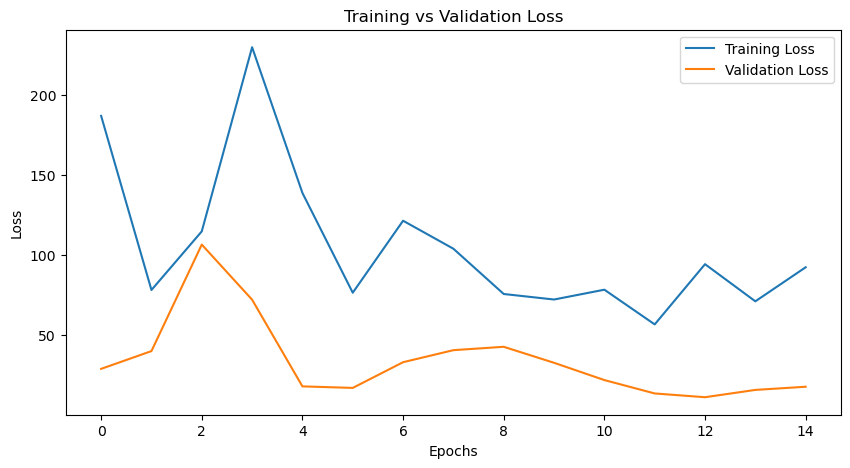

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.7816


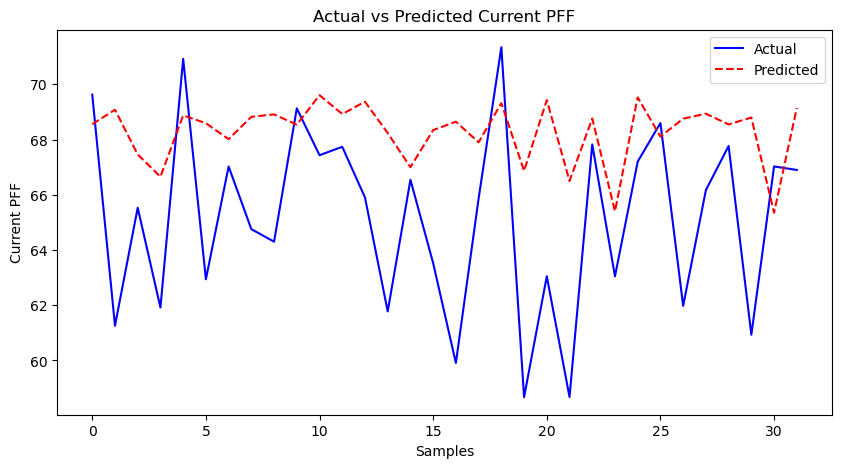

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 70.3096 - val_loss: 10.8804
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.8004 - val_loss: 11.5448
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.4355 - val_loss: 11.1175
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.6784 - val_loss: 10.0242
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.0878 - val_loss: 10.3859
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.0007 - val_loss: 10.6463
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 88.3955 - val_loss: 10.2230
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.7346 - val_loss: 10.2616
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.1896 - val_loss: 9.8711
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8457 - val_loss: 11.4883
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.4675 - val_loss: 14.5555
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.4976 - val_loss

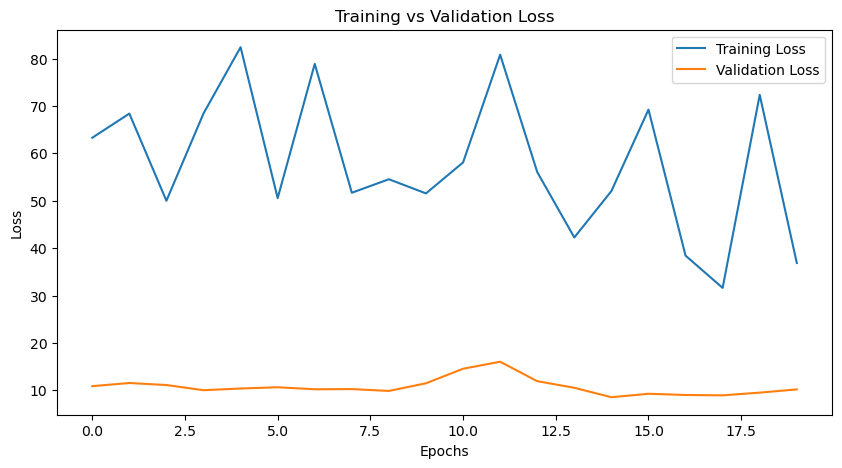

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.2391


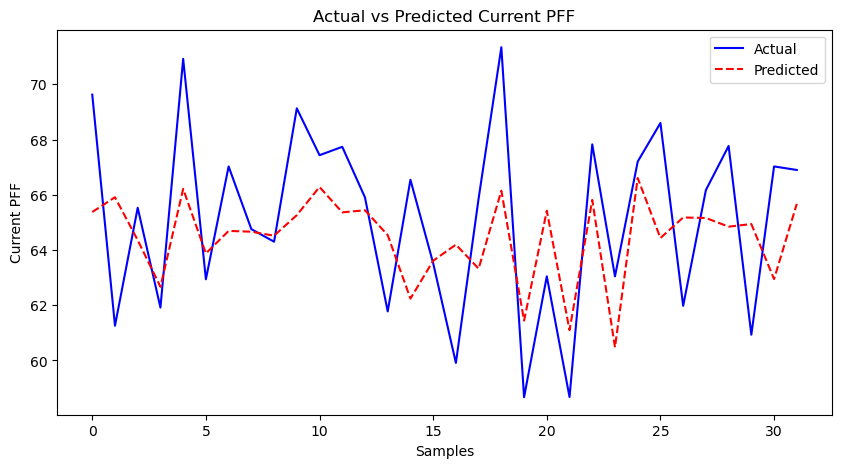

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51.1827 - val_loss: 9.9759
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69.3514 - val_loss: 10.2530
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 112.2536 - val_loss: 10.2401
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.0606 - val_loss: 12.0026
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.9694 - val_loss: 12.4675
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.0403 - val_loss: 11.3516
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.1214 - val_loss: 11.0866
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.4699 - val_loss: 13.2322
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.4618 - val_loss: 17.9999
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.8394 - val_loss: 14.1780
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.2920 - val_loss: 10.7799
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.5578 - val_los

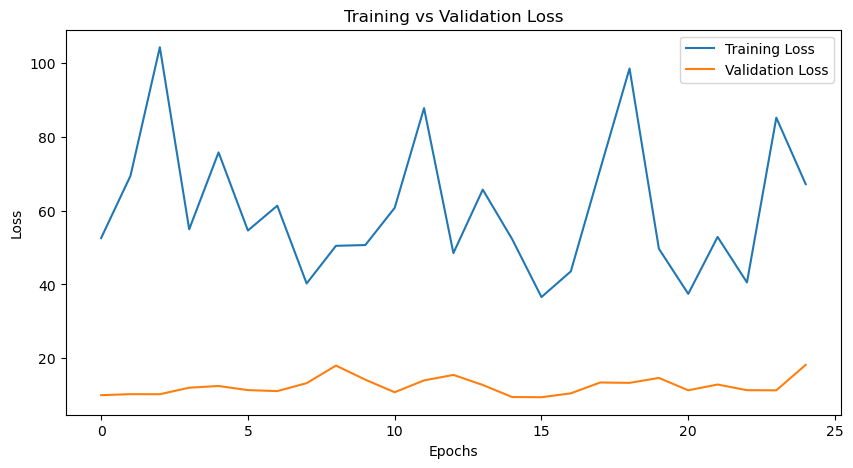

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.4904


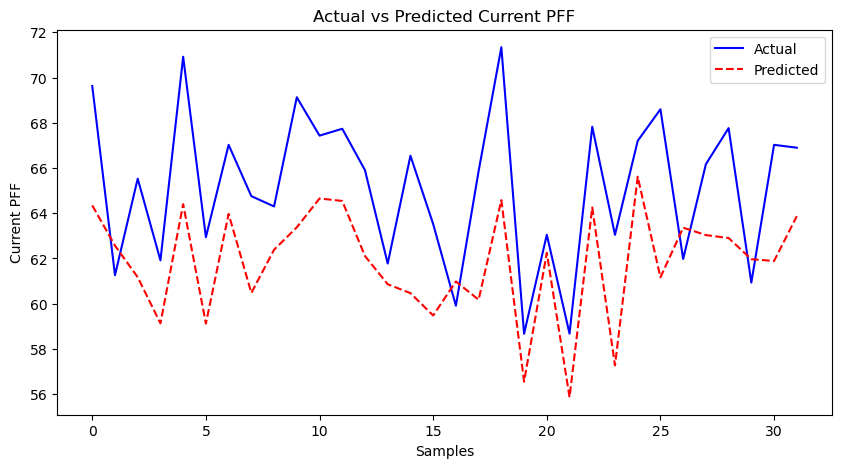

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66.1059 - val_loss: 13.9786
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.9918 - val_loss: 9.5323
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.9017 - val_loss: 9.7018
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.4757 - val_loss: 13.3051
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.0800 - val_loss: 13.8360
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97.8900 - val_loss: 9.9159
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9887 - val_loss: 11.6039
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.4845 - val_loss: 11.9084
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.7661 - val_loss: 10.9295
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.3752 - val_loss: 9.5326
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.9107 - val_loss: 11.0278
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.7052 - val_loss: 1

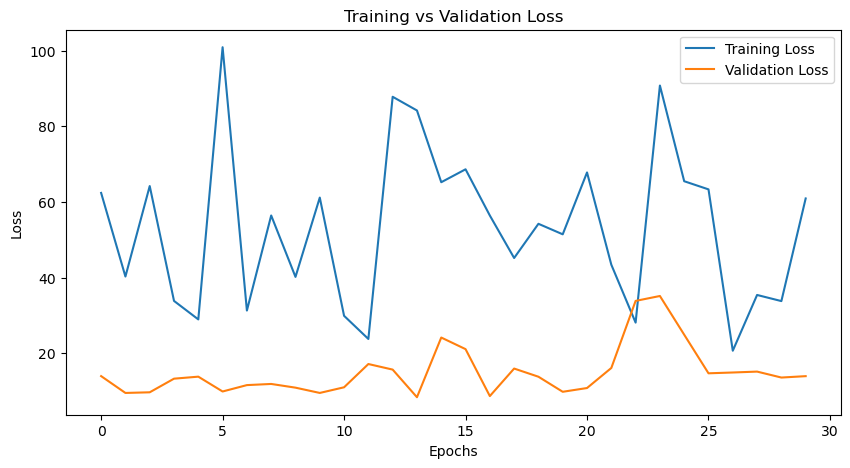

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.4865


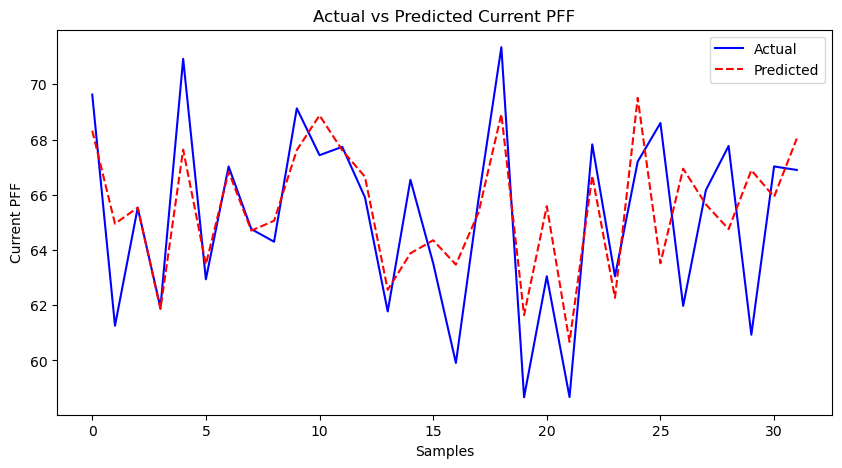

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57.0237 - val_loss: 14.9763
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.7587 - val_loss: 16.5099
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.5186 - val_loss: 15.4608
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.1257 - val_loss: 14.5572
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.4642 - val_loss: 16.4959
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.5061 - val_loss: 17.2361
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.1219 - val_loss: 16.0474
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.0792 - val_loss: 20.0346
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.1327 - val_loss: 14.8676
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.0361 - val_loss: 15.0426
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.5494 - val_loss: 16.1594
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.0132 - val_lo

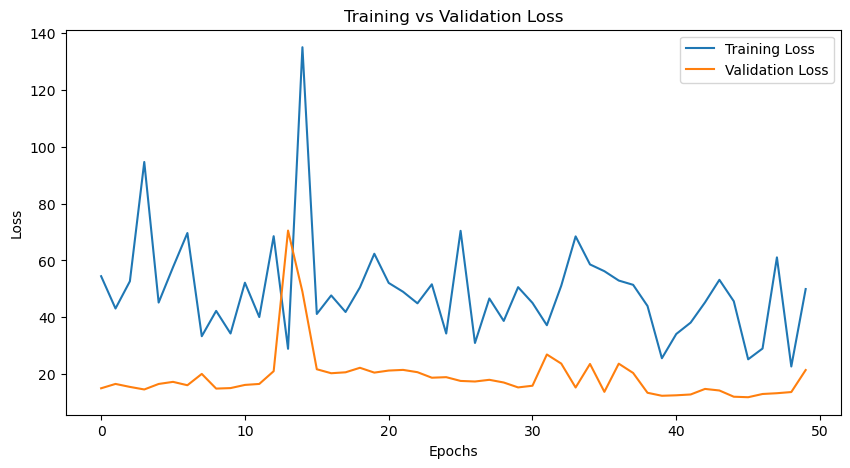

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.4518


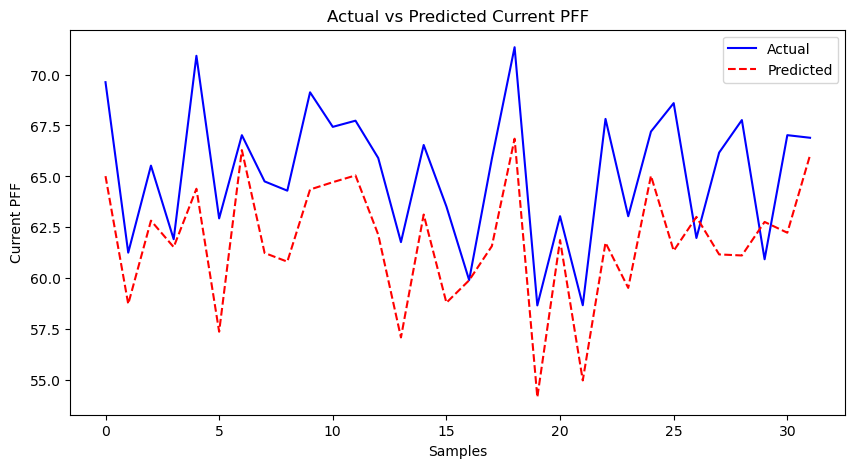

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 59.3820 - val_loss: 21.2039
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.3086 - val_loss: 12.4600
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.0385 - val_loss: 13.7096
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.0091 - val_loss: 15.0636
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.8556 - val_loss: 18.5058
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.7227 - val_loss: 20.5930
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.7508 - val_loss: 20.8197
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.1688 - val_loss: 20.1024
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.6374 - val_loss: 25.2500
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.5000 - val_loss: 25.0720
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.5947 - val_loss: 14.5822
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.18

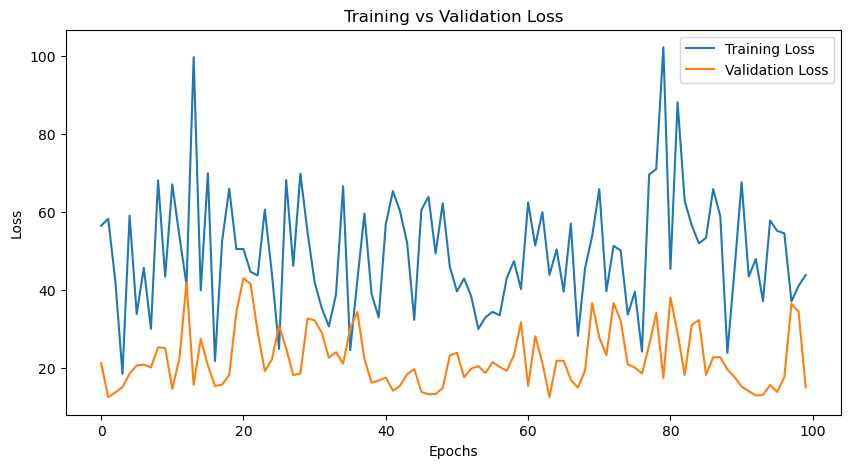

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.4342


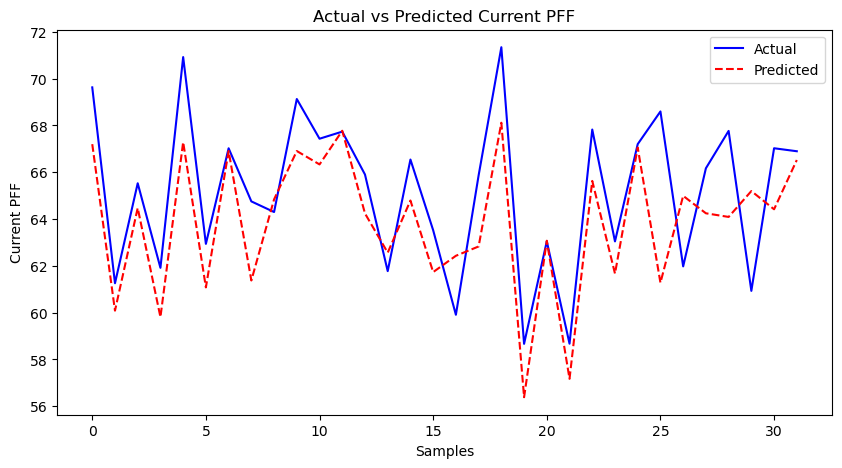

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.2708 - val_loss: 18.6249
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.5158 - val_loss: 15.5239
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.1854 - val_loss: 12.0425
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.3814 - val_loss: 12.9029
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.3441 - val_loss: 11.9047
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.3339 - val_loss: 13.6789
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.2507 - val_loss: 18.2079
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.0954 - val_loss: 15.5474
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.3608 - val_loss: 14.3171
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.8964 - val_loss: 17.1047
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.6864 - val_loss: 18.0776
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.25

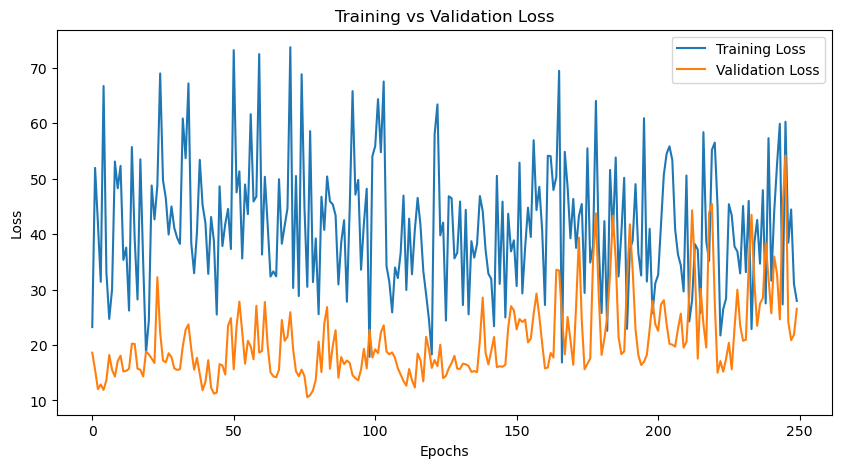

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.2212


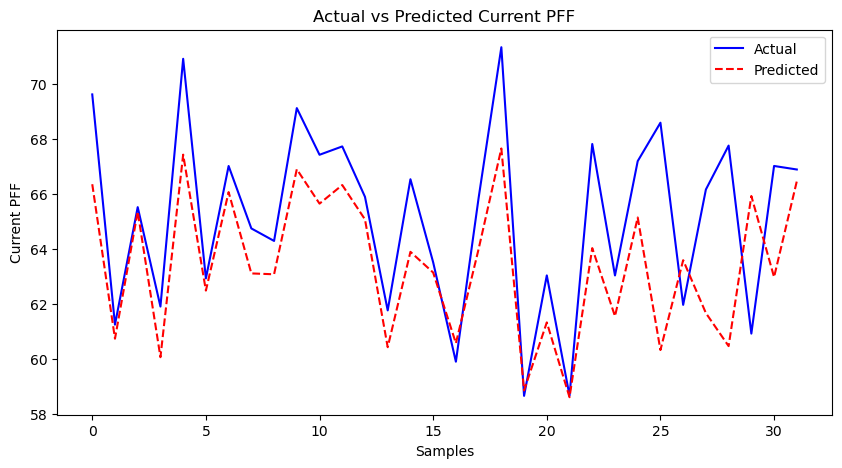

In [13]:
# Train the model
#history = model.fit(X, y, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping])
epoch_list = [5, 10, 15, 20, 25, 30, 50, 100, 250]
for e in epoch_list:
    history = model.fit(X, y, epochs=e, batch_size=8, validation_split=0.2)
    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Make predictions on the test set
    y_pred = model.predict(X)
    from sklearn.metrics import r2_score

    # Calculate R² score
    r2 = r2_score(y, y_pred)

    # Print R² score
    print(f"R² Score: {r2:.4f}")
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
    plt.title('Actual vs Predicted Current PFF')
    plt.xlabel('Samples')
    plt.ylabel('Current PFF')
    plt.legend()
    plt.show()

In [14]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Function to prepare data sequences for a given target metric
def prepare_sequences(df, target_metric, sequence_length=3):
    sequences = []
    targets = []
    team_data = df.groupby('Team')

    for team, group in team_data:
        # Ensure the team has enough data
        if len(group) >= sequence_length + 1:
            # Iterate through the data to create sequences
            for i in range(len(group) - sequence_length):
                # Select the relevant columns for the sequence
                sequence = group.iloc[i:i+sequence_length][[
                    'Previous_grades_tackle', 
                    'Previous_AV',
                    'Previous_PFF',
                    'Previous_franchise_id',
                    'Previous_grades_run_defense',
                    'Previous_grades_coverage_defense',
                    'Previous_tackles_for_loss'
                ]]
                
                # The target is the next year's target_metric
                target = group.iloc[i+sequence_length][target_metric]
                
                sequences.append(sequence.values)
                targets.append(target)
    
    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)
    
    print(f"Total sequences generated for {target_metric}: {len(sequences)}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    # Reshape X to (samples, timesteps, features)
    X = X.reshape(X.shape[0], sequence_length, -1)
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    return X, y, scaler


In [16]:
# Function to build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)  # (timesteps, features)
    
    # Add a Dense layer before the attention to create more variability in the input
    dense_input = Dense(16, activation='relu')(inputs)
    
    # Add MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)
    
    # Add Layer Normalization for stability
    attention_output = LayerNormalization()(attention_output)
    
    # Add RNN layer to capture temporal dependencies
    rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)
    
    # Add Dropout to prevent overfitting
    rnn_output = Dropout(0.2)(rnn_output)
    
    # Output layer for predicting the target metric
    output = Dense(1)(rnn_output)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [17]:
# Function to train and evaluate the model
def train_and_evaluate(X, y, target_metric, epochs_list, batch_size=8):
    input_shape = (X.shape[1], X.shape[2])  # (timesteps, features)
    model = build_model(input_shape)
    
    for e in epochs_list:
        print(f"\nTraining {target_metric} with {e} epochs...")
        history = model.fit(
            X, y, 
            epochs=e, 
            batch_size=batch_size, 
            validation_split=0.2, 
            verbose=1
        )
        
        # Plot training & validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss for {target_metric} - {e} Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Make predictions on the entire dataset (you might want to separate into train/test)
        y_pred = model.predict(X)
        
        # Calculate R² score
        r2 = r2_score(y, y_pred)
        print(f"R² Score for {target_metric} after {e} epochs: {r2:.4f}")
        
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 5))
        plt.scatter(range(len(y)), y, label='Actual', color='blue', alpha=0.5)
        plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', alpha=0.5)
        plt.title(f'Actual vs Predicted {target_metric} after {e} Epochs')
        plt.xlabel('Samples')
        plt.ylabel(target_metric)
        plt.legend()
        plt.show()

First few rows of the DataFrame:
      Team  Year Position  Value_cap_space  Value_draft_data  Current_AV  \
17   49ers  2019       DB        15.313496        270.589442        35.0   
50   49ers  2020       DB        13.657921        257.525536        36.0   
70   49ers  2021       DB         7.895890        247.080988        34.0   
123  49ers  2022       DB        11.383285        101.033420        45.0   
12   Bears  2019       DB        19.373007        241.860963        43.0   

     Current_PFF Total DVOA  win-loss-pct  Net EPA  ...  \
17     74.600742     27.90%      0.812500    0.216  ...   
50     66.704119      5.40%      0.375000    0.025  ...   
70     62.219454     19.50%      0.588235    0.081  ...   
123    69.627066     27.60%      0.764706    0.196  ...   
12     66.382439     -2.10%      0.500000   -0.032  ...   

     Previous_snap_counts_slot  Previous_stops  Previous_tackles  \
17                  105.954181        8.742204         29.438840   
50                 

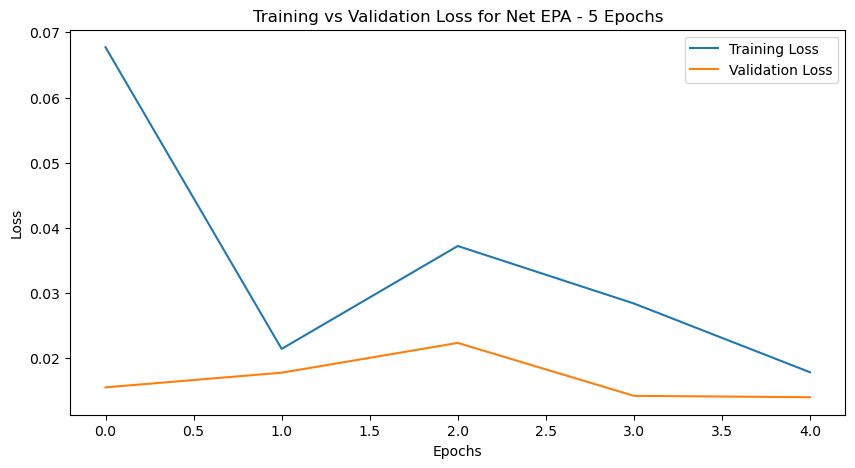

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
R² Score for Net EPA after 5 epochs: -0.1750
MAE for Net EPA after 5 epochs: 0.0996
RMSE for Net EPA after 5 epochs: 0.1183


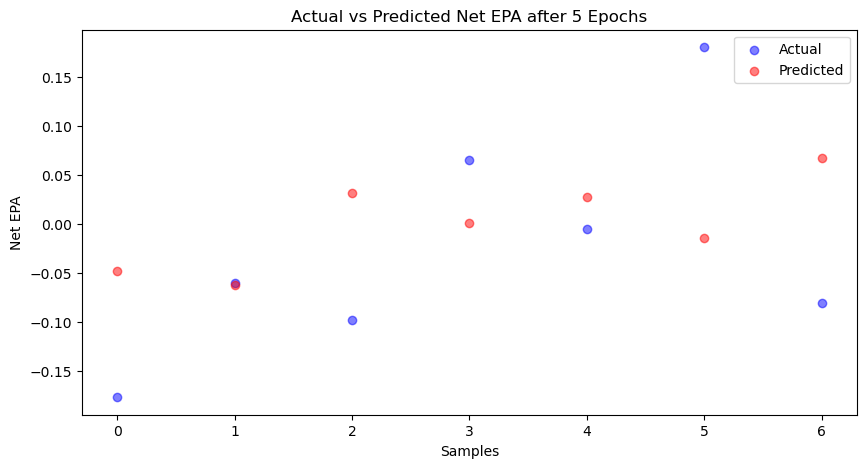


Training Net EPA with 10 epochs...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263 - val_loss: 0.0177
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0209
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0216
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val_loss: 0.0199
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0194
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val_loss: 0.0194
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0195
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0188


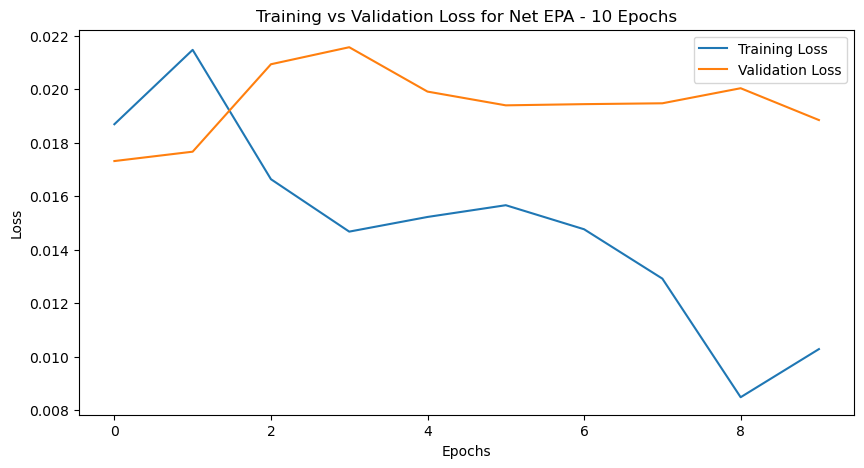

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R² Score for Net EPA after 10 epochs: -0.4533
MAE for Net EPA after 10 epochs: 0.1154
RMSE for Net EPA after 10 epochs: 0.1316


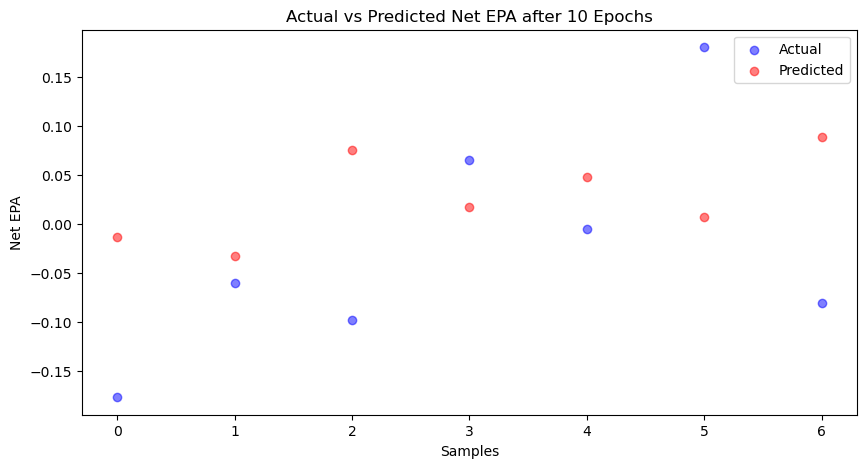


Training Net EPA with 15 epochs...
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - val_loss: 0.0168
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0177
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0183
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0214
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0220
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0193
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0187
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0200
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0222
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0201
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0197
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

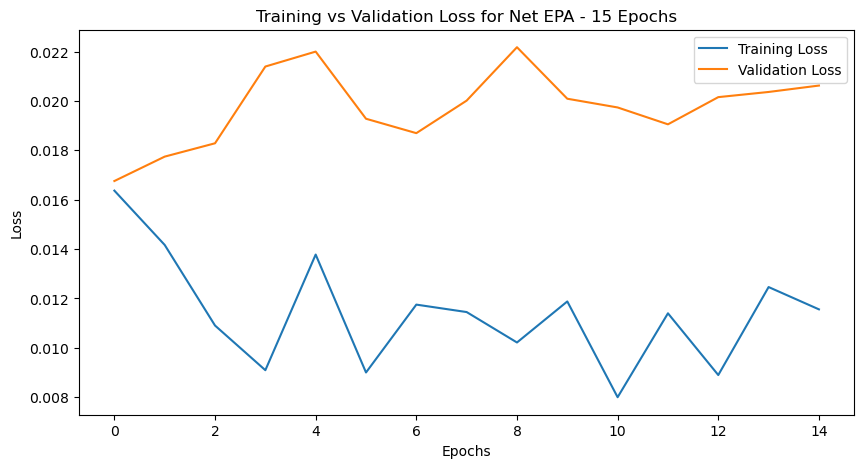

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 15 epochs: -0.4066
MAE for Net EPA after 15 epochs: 0.1117
RMSE for Net EPA after 15 epochs: 0.1294


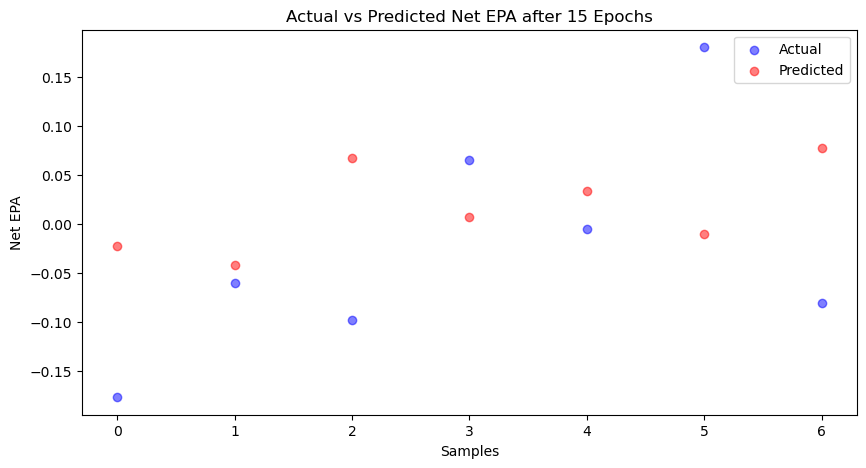


Training Net EPA with 20 epochs...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0183
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0188
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0168
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0174
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0146
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0146
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0145
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0166
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0189
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0197
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0187
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

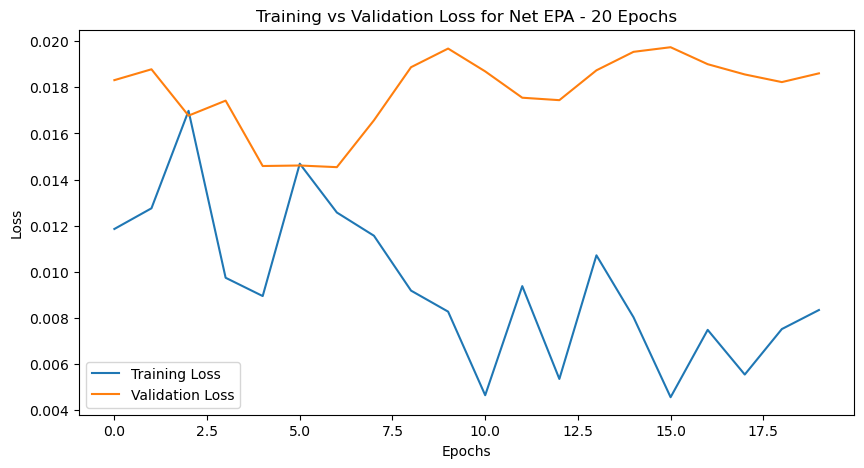

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 20 epochs: -0.2203
MAE for Net EPA after 20 epochs: 0.1055
RMSE for Net EPA after 20 epochs: 0.1206


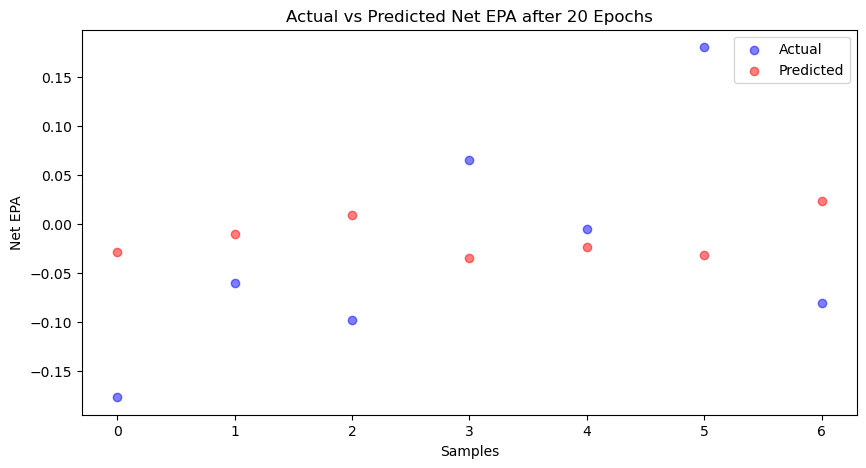


Training Net EPA with 25 epochs...
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0137
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0139
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0127
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0110
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0141
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0168
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0167
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0137
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

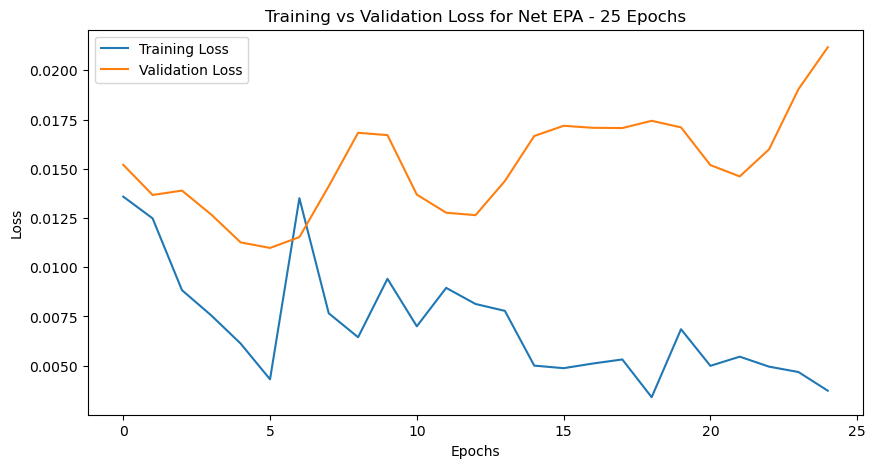

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² Score for Net EPA after 25 epochs: 0.0783
MAE for Net EPA after 25 epochs: 0.0883
RMSE for Net EPA after 25 epochs: 0.1048


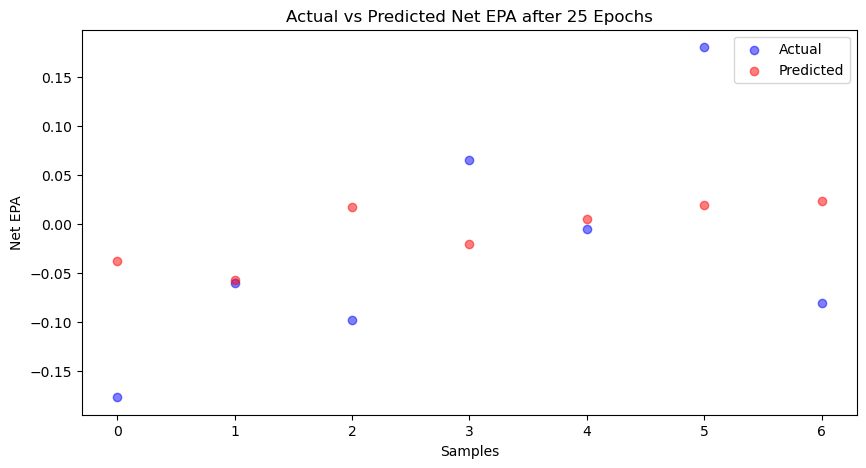


Training Net EPA with 30 epochs...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0124
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0257
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0209
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0189
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0184
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0174
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0175
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0212
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0234
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0231
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

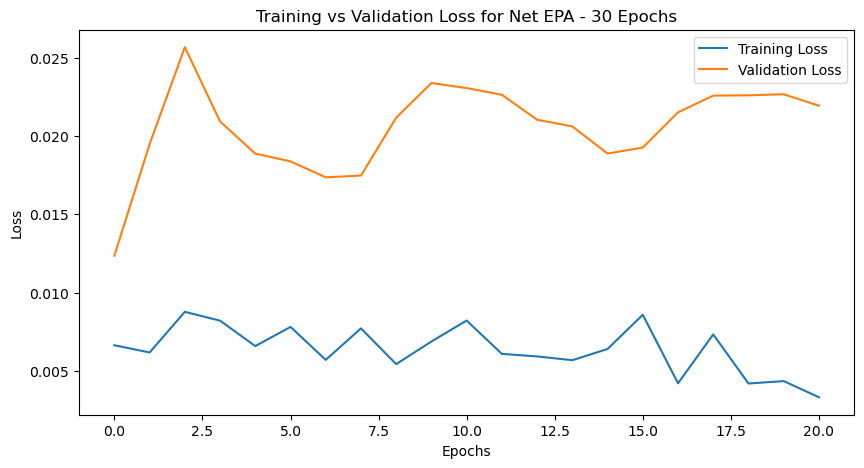

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² Score for Net EPA after 30 epochs: -0.0369
MAE for Net EPA after 30 epochs: 0.0967
RMSE for Net EPA after 30 epochs: 0.1111


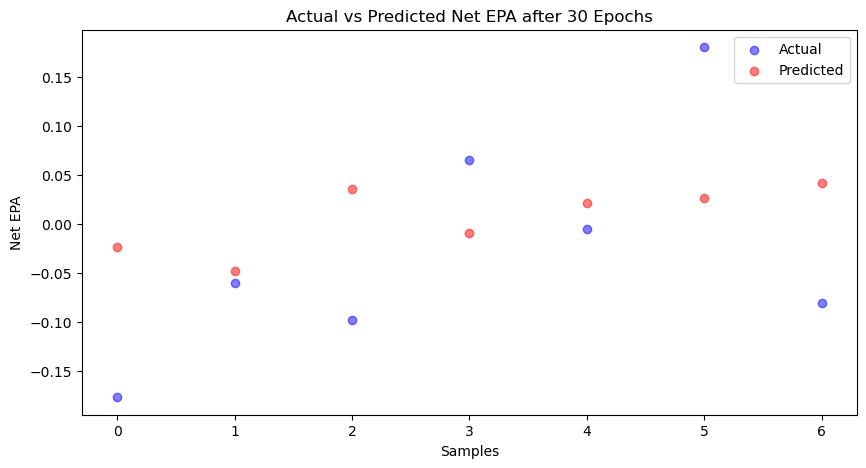


Training Net EPA with 50 epochs...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0143
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0140
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0140
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0138
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0139
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0144
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0157
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0162
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0166
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0167
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

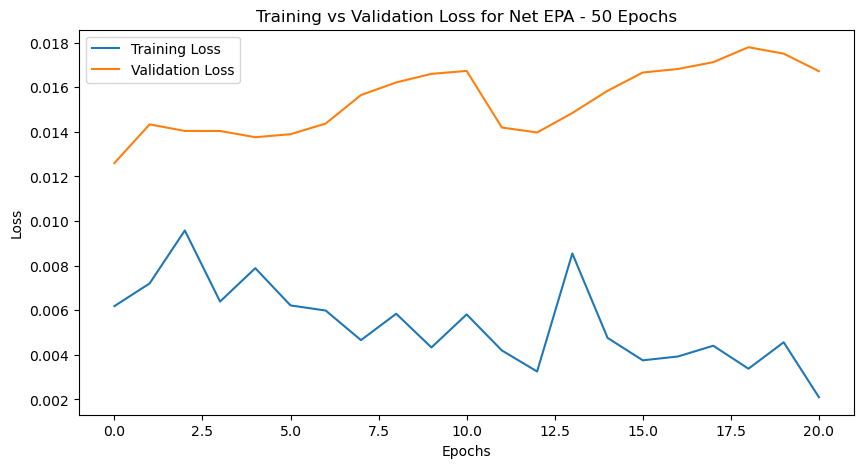

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 50 epochs: -0.0574
MAE for Net EPA after 50 epochs: 0.0980
RMSE for Net EPA after 50 epochs: 0.1122


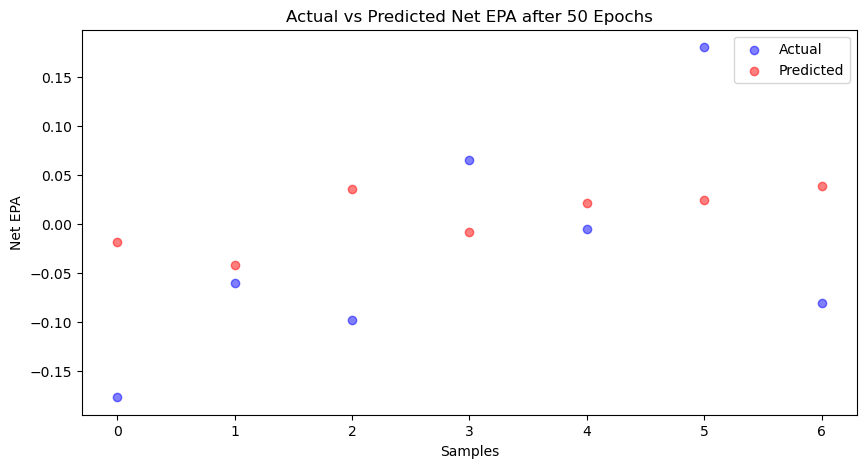


Training Net EPA with 100 epochs...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0128
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0126
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0123
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0127
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0138
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0154
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0175
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0184
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0176
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0177
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

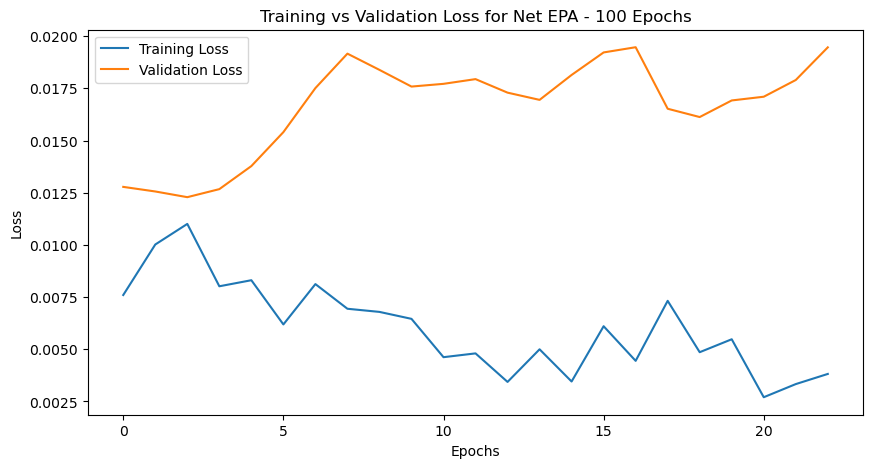

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 100 epochs: -0.0314
MAE for Net EPA after 100 epochs: 0.0911
RMSE for Net EPA after 100 epochs: 0.1108


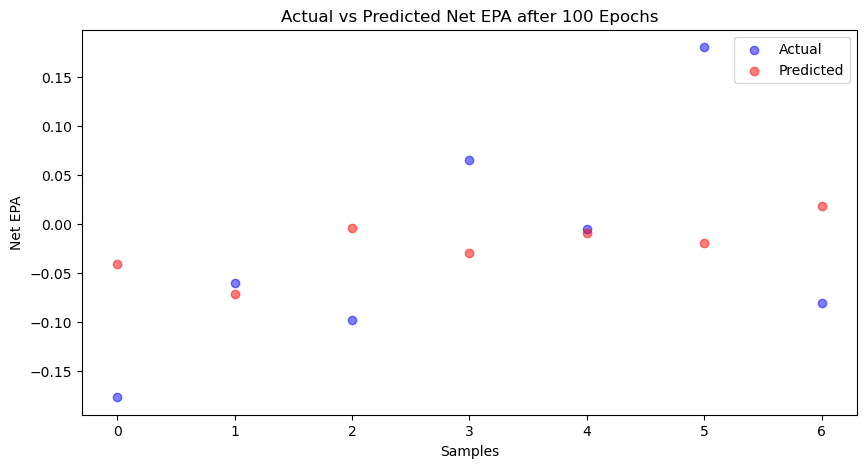


Training Net EPA with 250 epochs...
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0128
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0128
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0128
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0140
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0185
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0251
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0230
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0209
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0206
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0215
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0274
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

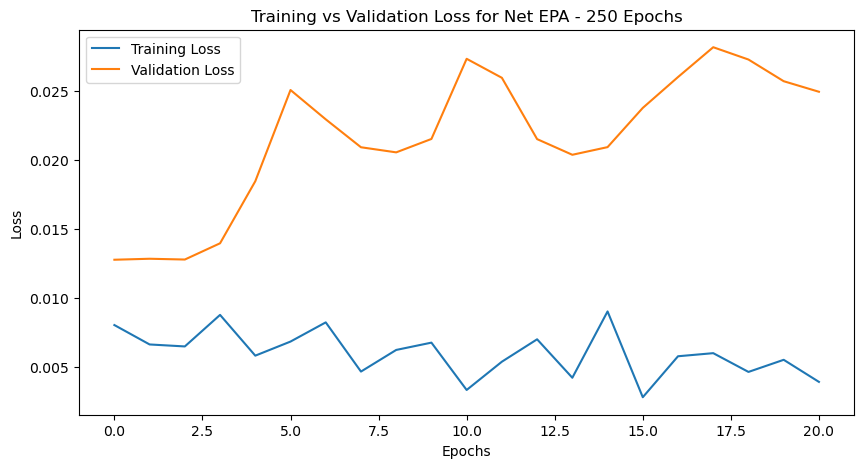

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score for Net EPA after 250 epochs: -0.0716
MAE for Net EPA after 250 epochs: 0.0946
RMSE for Net EPA after 250 epochs: 0.1130


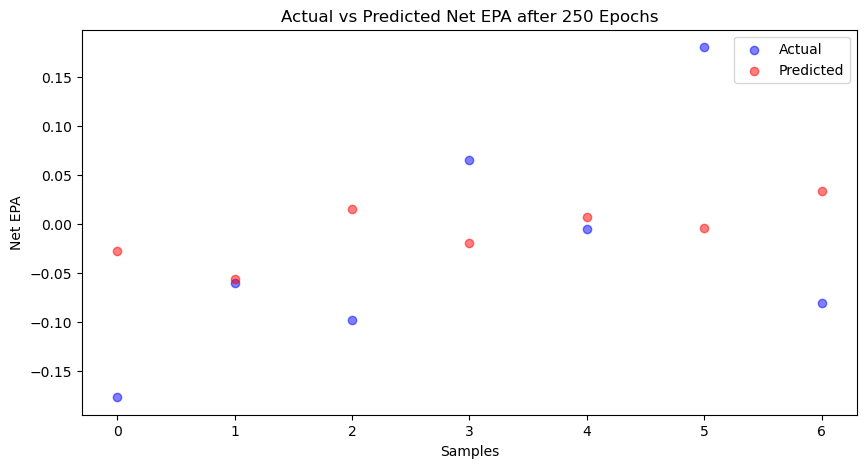


Preparing data for target metric: Total DVOA
Total sequences generated for Total DVOA: 32
X shape: (32, 3, 7), y shape: (32,)

Data Types in X_train: float64
Data Types in X_test: float64
Data Types in y_train: float64
Data Types in y_test: float64

Training Total DVOA with 5 epochs...
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0420 - val_loss: 0.0286
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0488 - val_loss: 0.0257
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0252
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.0256
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.0273


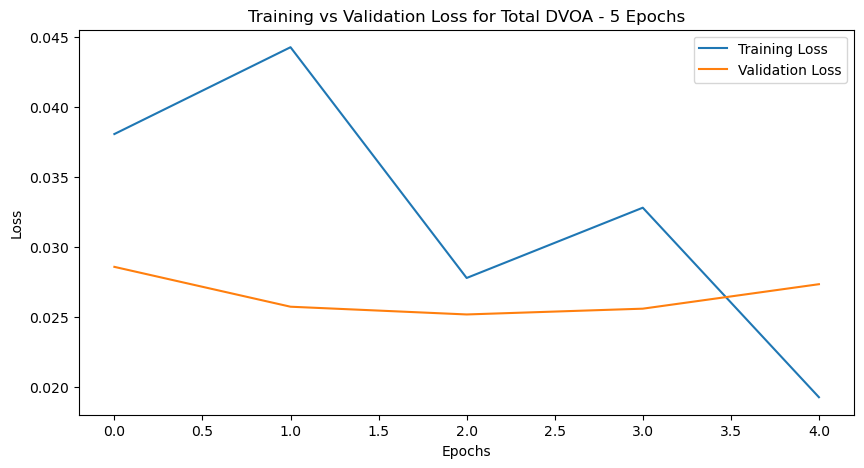

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
R² Score for Total DVOA after 5 epochs: -0.2708
MAE for Total DVOA after 5 epochs: 0.1049
RMSE for Total DVOA after 5 epochs: 0.1586


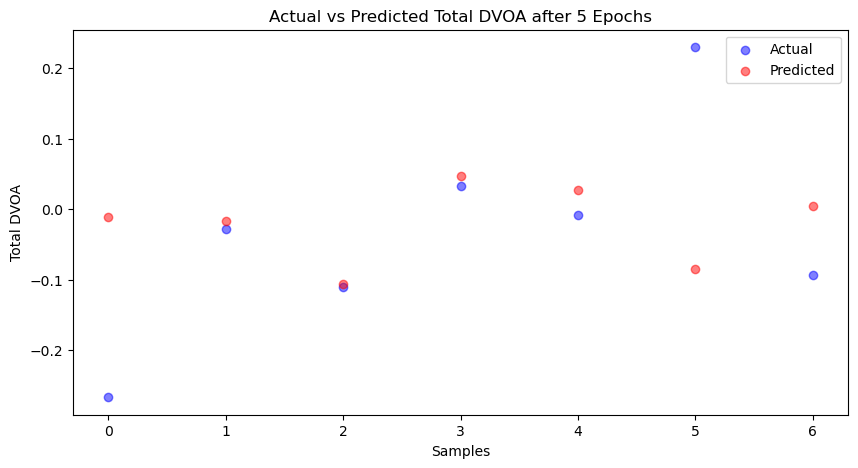


Training Total DVOA with 10 epochs...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0275 - val_loss: 0.0284
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0382
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0417
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0281 - val_loss: 0.0395
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - val_loss: 0.0333
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - val_loss: 0.0254
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0220
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0227
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0264
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.0325


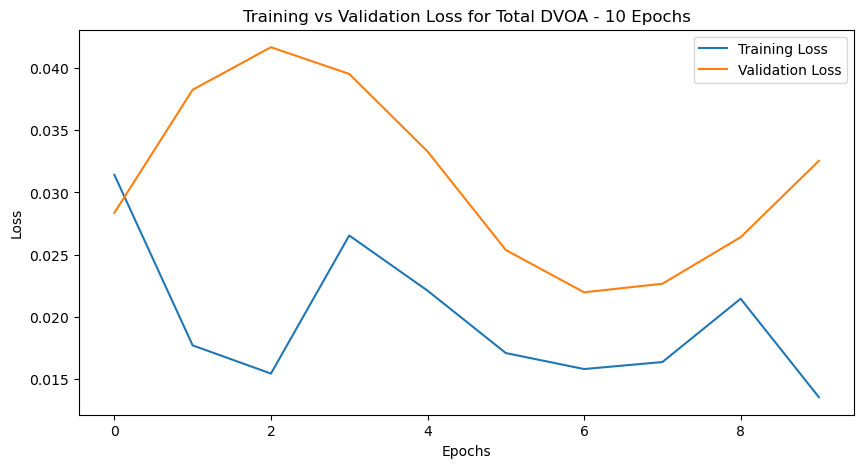

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 10 epochs: -0.1105
MAE for Total DVOA after 10 epochs: 0.1107
RMSE for Total DVOA after 10 epochs: 0.1483


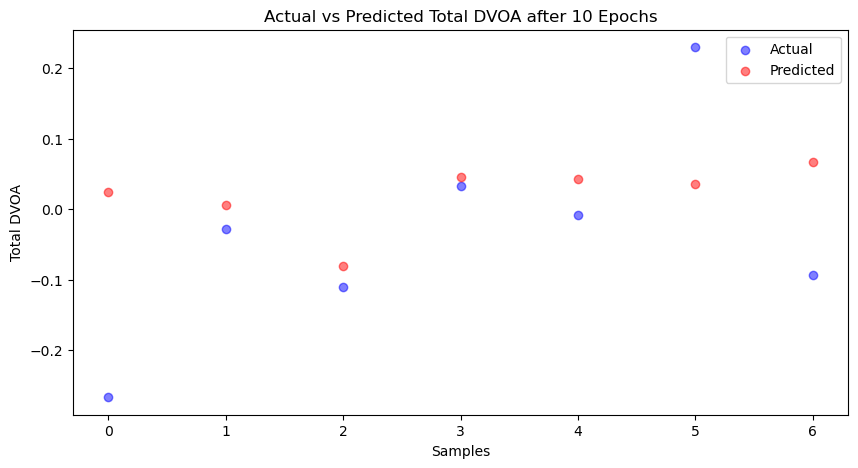


Training Total DVOA with 15 epochs...
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221 - val_loss: 0.0278
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0382
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0358
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0277
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0232
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0221
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0231
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0281
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0333
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0324
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0269
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

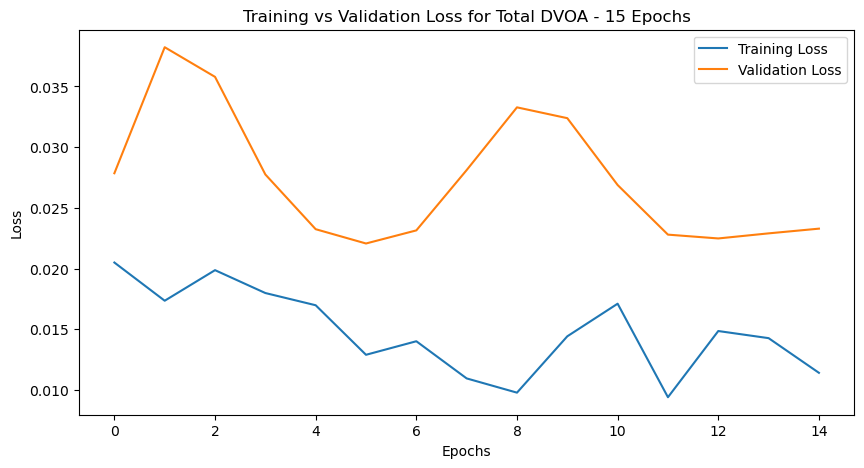

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score for Total DVOA after 15 epochs: -0.1146
MAE for Total DVOA after 15 epochs: 0.1075
RMSE for Total DVOA after 15 epochs: 0.1485


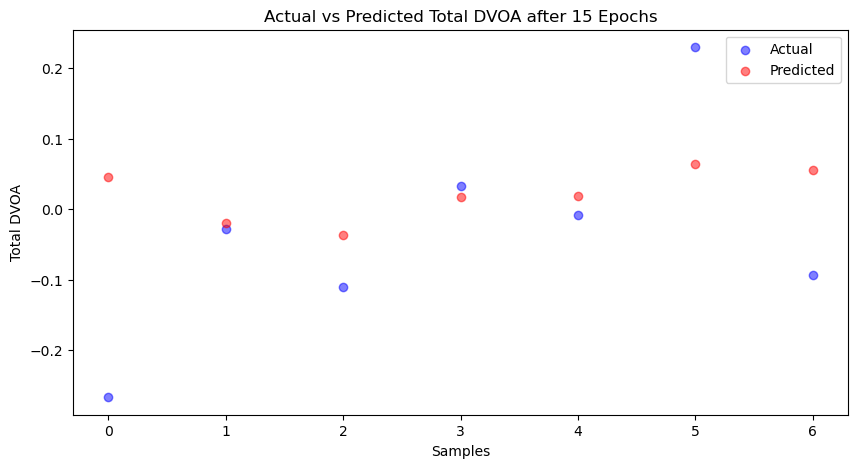


Training Total DVOA with 20 epochs...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - val_loss: 0.0238
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0263
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0264
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0259
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_loss: 0.0276
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0315
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0334
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0339
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0305
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0275
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0275
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

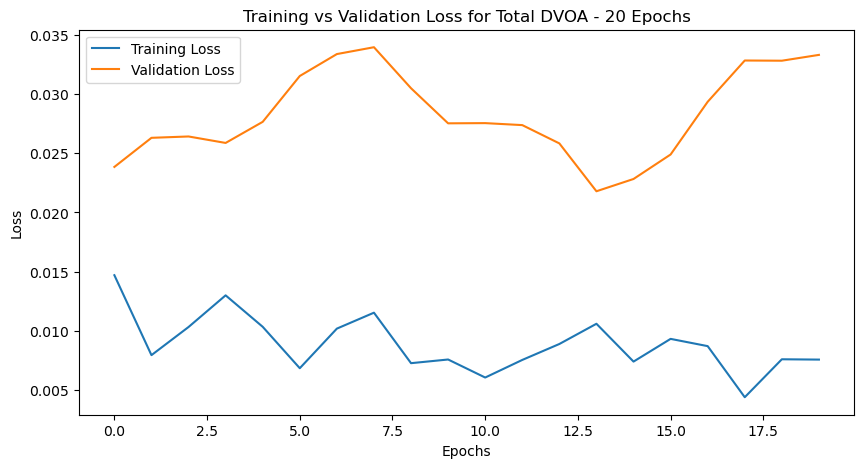

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 20 epochs: -0.1008
MAE for Total DVOA after 20 epochs: 0.1057
RMSE for Total DVOA after 20 epochs: 0.1476


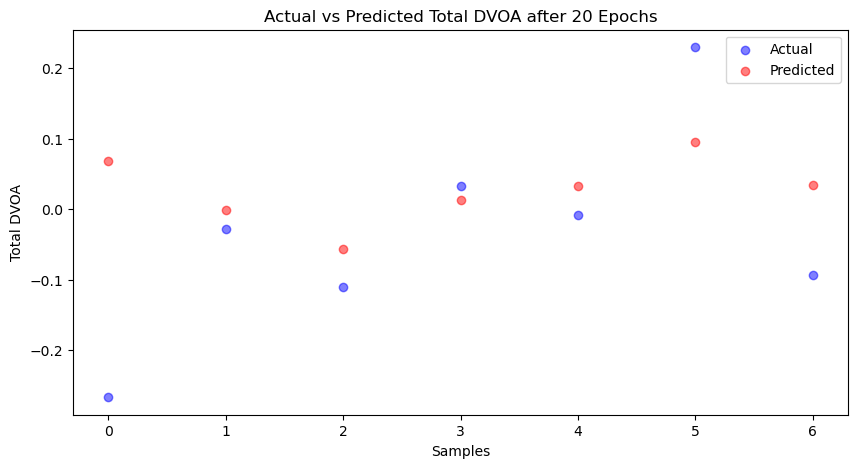


Training Total DVOA with 25 epochs...
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - val_loss: 0.0259
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0339
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0342
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0307
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0279
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0250
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0254
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0294
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0348
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0371
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0370
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

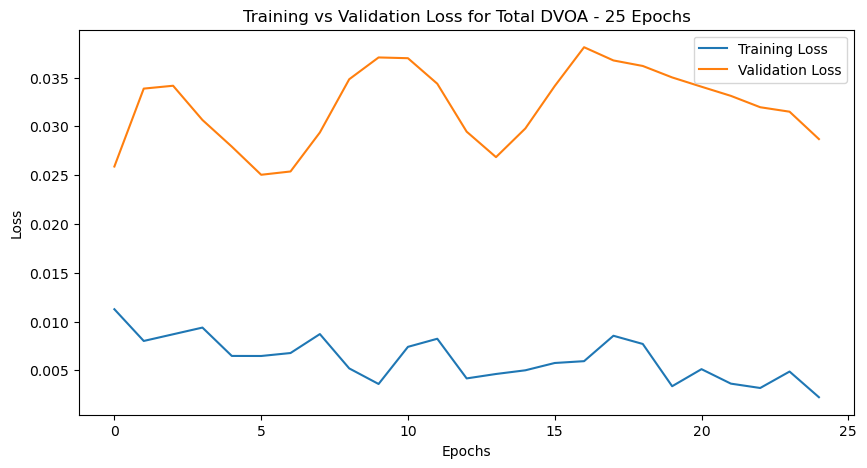

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² Score for Total DVOA after 25 epochs: -0.2650
MAE for Total DVOA after 25 epochs: 0.1144
RMSE for Total DVOA after 25 epochs: 0.1582


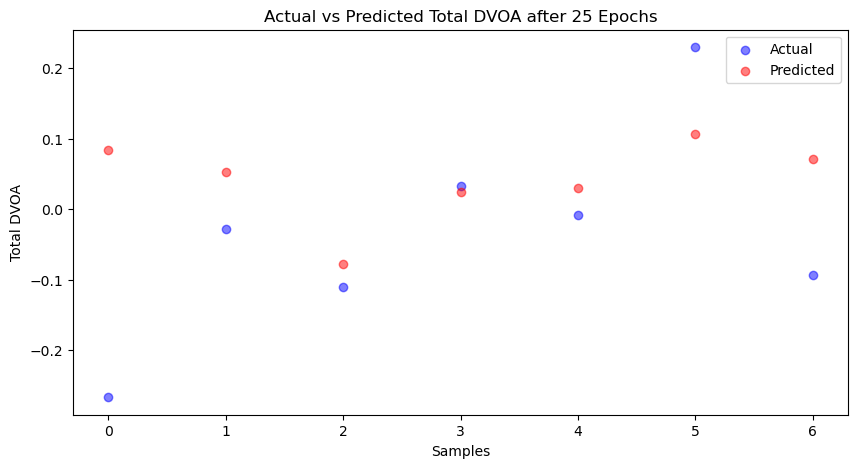


Training Total DVOA with 30 epochs...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0241
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0245
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0270
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0310
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0325
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0340
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0339
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0294
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0276
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0286
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0298
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

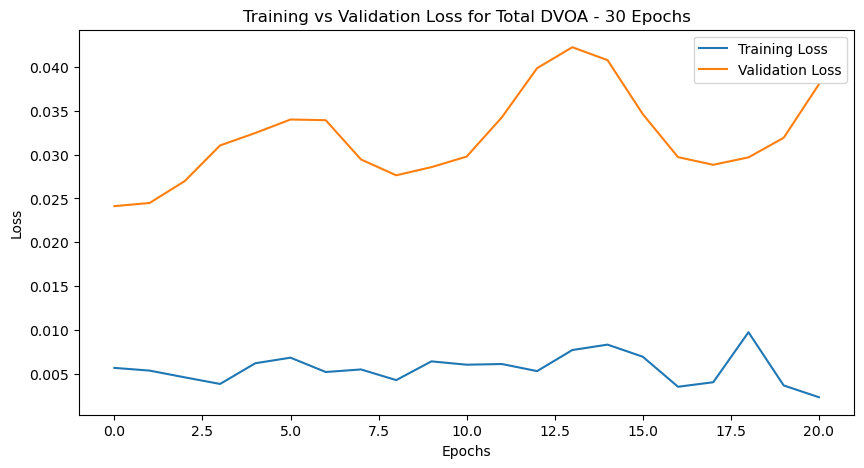

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 30 epochs: -0.2184
MAE for Total DVOA after 30 epochs: 0.1070
RMSE for Total DVOA after 30 epochs: 0.1553


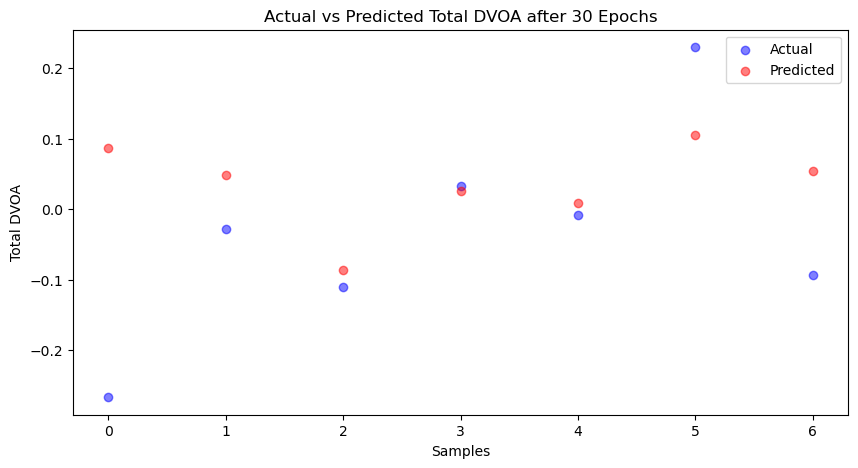


Training Total DVOA with 50 epochs...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - val_loss: 0.0291
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0369
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0413
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0392
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0323
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0274
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0251
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0242
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0270
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0297
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0329
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

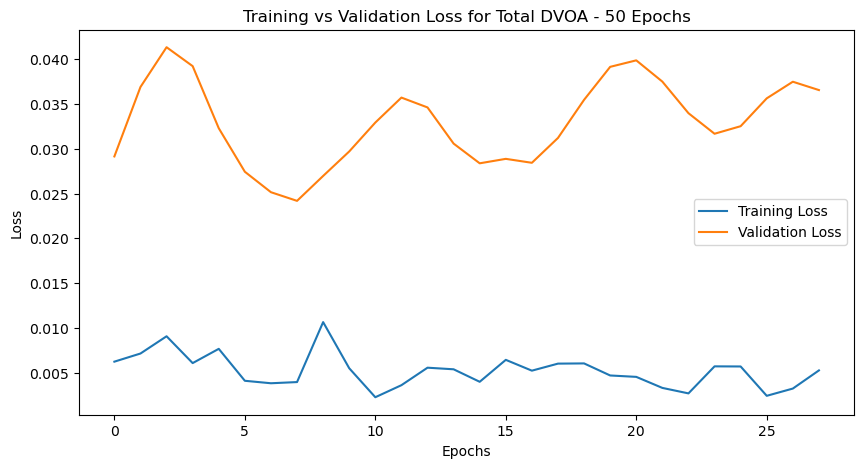

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R² Score for Total DVOA after 50 epochs: -0.2215
MAE for Total DVOA after 50 epochs: 0.1208
RMSE for Total DVOA after 50 epochs: 0.1555


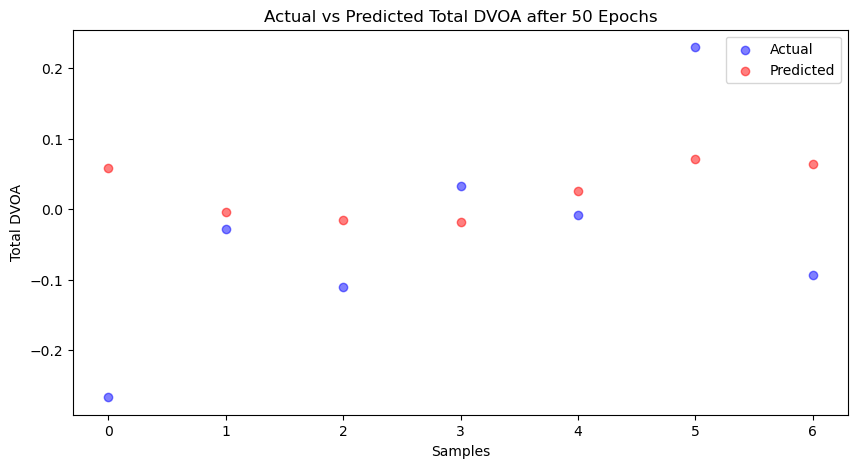


Training Total DVOA with 100 epochs...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - val_loss: 0.0252
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0269
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0309
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0348
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0343
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0346
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0372
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0371
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0336
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0316
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0329
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

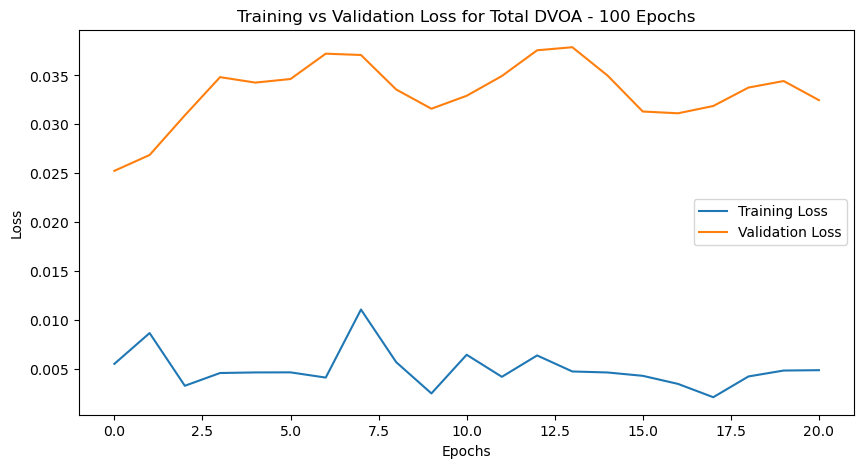

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score for Total DVOA after 100 epochs: -0.2756
MAE for Total DVOA after 100 epochs: 0.1205
RMSE for Total DVOA after 100 epochs: 0.1589


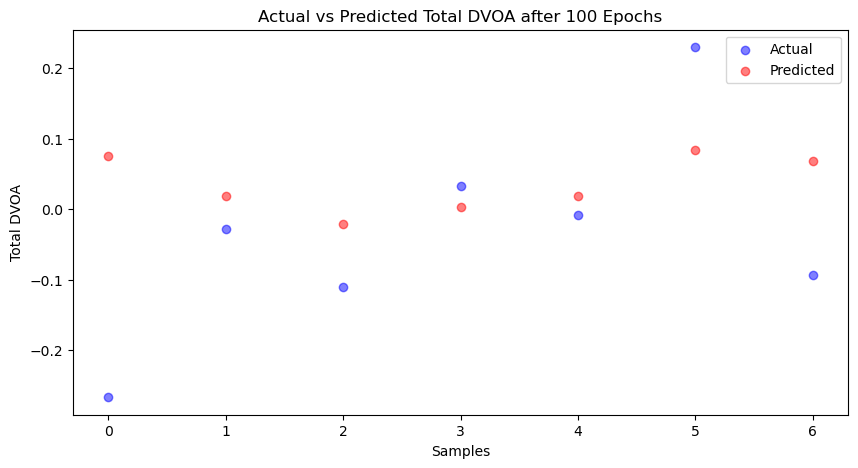


Training Total DVOA with 250 epochs...
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0264
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0300
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0345
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0398
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0415
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0376
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0344
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0325
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0290
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0258
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0310
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

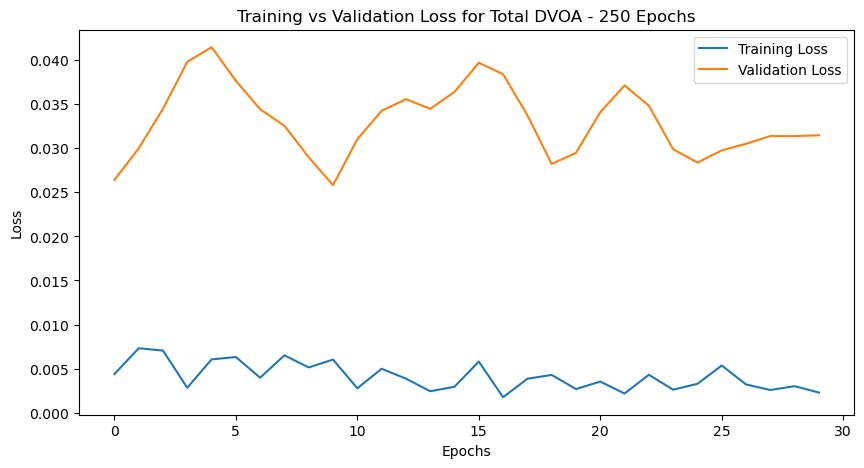

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R² Score for Total DVOA after 250 epochs: -0.3041
MAE for Total DVOA after 250 epochs: 0.1164
RMSE for Total DVOA after 250 epochs: 0.1607


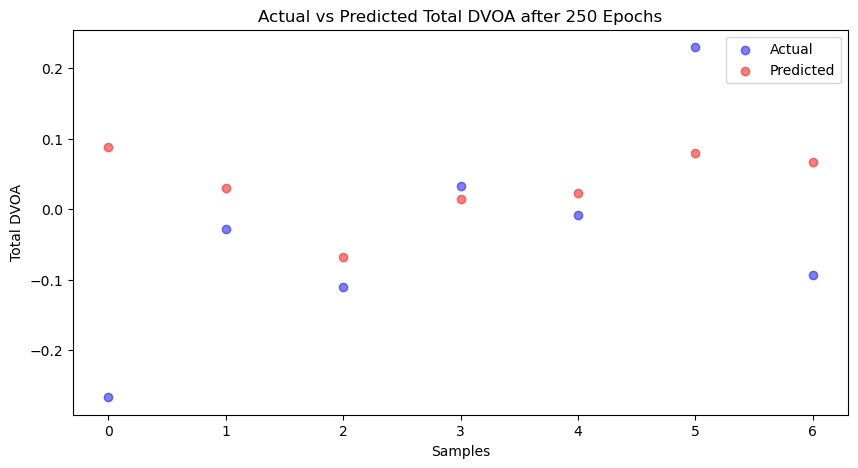

In [53]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

# Function to clean percentage columns
def clean_percentage_column(df, column):
    # Remove '%' and convert to float, then divide by 100 if it's a percentage
    df[column] = df[column].str.replace('%', '').astype(float) / 100.0
    return df

# Function to prepare data sequences for a given target metric
def prepare_sequences(df, target_metric, feature_cols, sequence_length=3, test_size=0.2):
    sequences = []
    targets = []
    team_data = df.groupby('Team')

    for team, group in team_data:
        # Ensure the team has enough data
        if len(group) >= sequence_length + 1:
            # Iterate through the data to create sequences
            for i in range(len(group) - sequence_length):
                # Select the relevant columns for the sequence
                sequence = group.iloc[i:i+sequence_length][feature_cols]
                
                # The target is the next year's target_metric
                target = group.iloc[i+sequence_length][target_metric]
                
                sequences.append(sequence.values)
                targets.append(target)

    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)

    print(f"Total sequences generated for {target_metric}: {len(sequences)}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Reshape X to (samples, timesteps, features)
    X = X.reshape(X.shape[0], sequence_length, -1)

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)  # (timesteps, features)
    
    # Add a Dense layer before the attention to create more variability in the input
    dense_input = Dense(16, activation='relu')(inputs)
    
    # Add MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)
    
    # Add Layer Normalization for stability
    attention_output = LayerNormalization()(attention_output)
    
    # Add LSTM layer to capture temporal dependencies
    lstm_output = LSTM(units=50, activation='relu')(attention_output)
    
    # Add Dropout to prevent overfitting
    lstm_output = Dropout(0.2)(lstm_output)
    
    # Output layer for predicting the target metric
    output = Dense(1)(lstm_output)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, target_metric, epochs_list, batch_size=8):
    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    model = build_model(input_shape)
    
    # Debugging: Check data types
    print("\nData Types in X_train:", X_train.dtype)
    print("Data Types in X_test:", X_test.dtype)
    print("Data Types in y_train:", y_train.dtype)
    print("Data Types in y_test:", y_test.dtype)
    
    # Check for any non-numeric data
    if not np.issubdtype(X_train.dtype, np.number):
        raise ValueError("X_train contains non-numeric data.")
    if not np.issubdtype(X_test.dtype, np.number):
        raise ValueError("X_test contains non-numeric data.")
    if not np.issubdtype(y_train.dtype, np.number):
        raise ValueError("y_train contains non-numeric data.")
    if not np.issubdtype(y_test.dtype, np.number):
        raise ValueError("y_test contains non-numeric data.")
    
    for e in epochs_list:
        print(f"\nTraining {target_metric} with {e} epochs...")
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        history = model.fit(
            X_train, y_train, 
            epochs=e, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Plot training & validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss for {target_metric} - {e} Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R² Score for {target_metric} after {e} epochs: {r2:.4f}")
        print(f"MAE for {target_metric} after {e} epochs: {mae:.4f}")
        print(f"RMSE for {target_metric} after {e} epochs: {rmse:.4f}")
        
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 5))
        plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', alpha=0.5)
        plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', alpha=0.5)
        plt.title(f'Actual vs Predicted {target_metric} after {e} Epochs')
        plt.xlabel('Samples')
        plt.ylabel(target_metric)
        plt.legend()
        plt.show()

# Main Execution
if __name__ == "__main__":
    # Load the data
    df = pd.read_csv('Combined_Secondary_Defense.csv')
    
    # Define the intended target metrics with correct column names
    intended_target_metrics = ['Net EPA', 'Total DVOA']  # Corrected target metrics
    
    # Drop unnecessary columns
    columns_to_drop = ['Unnamed: 0']
    df = df.drop(columns=columns_to_drop, errors='ignore')  # Use errors='ignore' to avoid issues if the column doesn't exist
    
    # Sort data by Team and Year
    df = df.sort_values(by=['Team', 'Year'])
    print("First few rows of the DataFrame:")
    print(df.head())
    
    # Get the actual columns present
    actual_columns = df.columns.tolist()
    
    # Filter target metrics to include only existing columns
    target_metrics = [metric for metric in intended_target_metrics if metric in actual_columns]
    
    # Notify the user about missing columns
    missing_metrics = [metric for metric in intended_target_metrics if metric not in actual_columns]
    if missing_metrics:
        print(f"Warning: The following target metrics are missing in the DataFrame and will be skipped: {missing_metrics}")
    
    # Encode 'Previous_franchise_id' if it exists
    if 'Previous_franchise_id' in actual_columns:
        print("Encoding 'Previous_franchise_id'...")
        label_encoder = LabelEncoder()
        df['Previous_franchise_id_encoded'] = label_encoder.fit_transform(df['Previous_franchise_id'])
        print("Encoding completed.")
    else:
        print("Warning: 'Previous_franchise_id' column is missing from the DataFrame.")
    
    # Update actual_columns after encoding
    actual_columns = df.columns.tolist()
    
    # Define feature columns with encoded 'Previous_franchise_id'
    feature_columns = [
        'Previous_grades_tackle', 
        'Previous_AV',
        'Previous_PFF',
        'Previous_franchise_id_encoded',  # Use the encoded column
        'Previous_grades_run_defense',
        'Previous_grades_coverage_defense',
        'Previous_tackles_for_loss'
    ]
    
    # Check if all feature columns exist
    missing_features = [feature for feature in feature_columns if feature not in actual_columns]
    if missing_features:
        print(f"Error: The following feature columns are missing in the DataFrame: {missing_features}")
        raise ValueError("Missing feature columns. Please verify your DataFrame.")
    
    # Verify that all feature columns are numeric
    print("\nVerifying that all feature columns are numeric...")
    non_numeric_features = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
    if non_numeric_features:
        print(f"Error: The following feature columns contain non-numeric data: {non_numeric_features}")
        raise ValueError("Non-numeric data found in feature columns. Please encode or convert them to numeric types.")
    else:
        print("All feature columns are numeric.")
    
    # Check and handle non-numeric entries in feature columns
    print("\nChecking for non-numeric entries in feature columns...")
    for col in feature_columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Converted '{col}' to numeric. Non-convertible values are set to NaN.")
    
    # Check for NaN values in feature and target columns
    print("\nChecking for NaN values in feature and target columns...")
    nan_counts = df[feature_columns + target_metrics].isnull().sum()
    print(nan_counts)
    
    # Handle NaN values in target metrics by cleaning percentage strings and converting to numeric
    for metric in target_metrics:
        if df[metric].dtype == 'object':
            # Check if the column contains '%'
            if df[metric].str.contains('%').any():
                print(f"\nCleaning percentage values in '{metric}'...")
                df = clean_percentage_column(df, metric)
                print(f"'{metric}' cleaned.")
            else:
                # Attempt to convert to numeric, coercing errors to NaN
                df[metric] = pd.to_numeric(df[metric], errors='coerce')
                print(f"Converted '{metric}' to numeric.")
    
    # Check for NaN values again after cleaning target metrics
    print("\nChecking for NaN values in target metrics after cleaning:")
    print(df[target_metrics].isnull().sum())
    
    # Drop rows with NaN in target metrics
    df_clean = df.dropna(subset=target_metrics)
    print(f"\nNumber of rows after dropping NaN in target metrics: {df_clean.shape[0]}")
    
    # Initialize the imputer with a strategy (e.g., mean)
    imputer = SimpleImputer(strategy='mean')
    
    # Fit and transform the feature columns
    df_clean[feature_columns] = imputer.fit_transform(df_clean[feature_columns])
    
    # Verify that there are no NaNs left in feature columns
    print("\nNumber of NaN values in feature columns after imputation:")
    print(df_clean[feature_columns].isnull().sum())
    
    # Convert X_train, X_test, y_train, y_test to appropriate data types
    # This is already handled in the prepare_sequences function
    
    # Iterate over each valid target metric
    for metric in target_metrics:
        print(f"\nPreparing data for target metric: {metric}")
        X_train, X_test, y_train, y_test, scaler = prepare_sequences(df_clean, metric, feature_columns)
        
        # Define the list of epochs you want to train for
        epoch_list = [5, 10, 15, 20, 25, 30, 50, 100, 250]
        
        # Train and evaluate the model
        train_and_evaluate(X_train, X_test, y_train, y_test, metric, epoch_list)
